In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import Xception  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import layers
import multiprocessing

2023-05-03 19:20:14.418918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 19:20:14.504719: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 19:20:14.506296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 19:20:15.562538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the path to the data directory
data_dir = "/media/DATA/soldering"

# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(train_dir, val_dir):
    train_counts = []
    val_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 8))
    rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
    rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

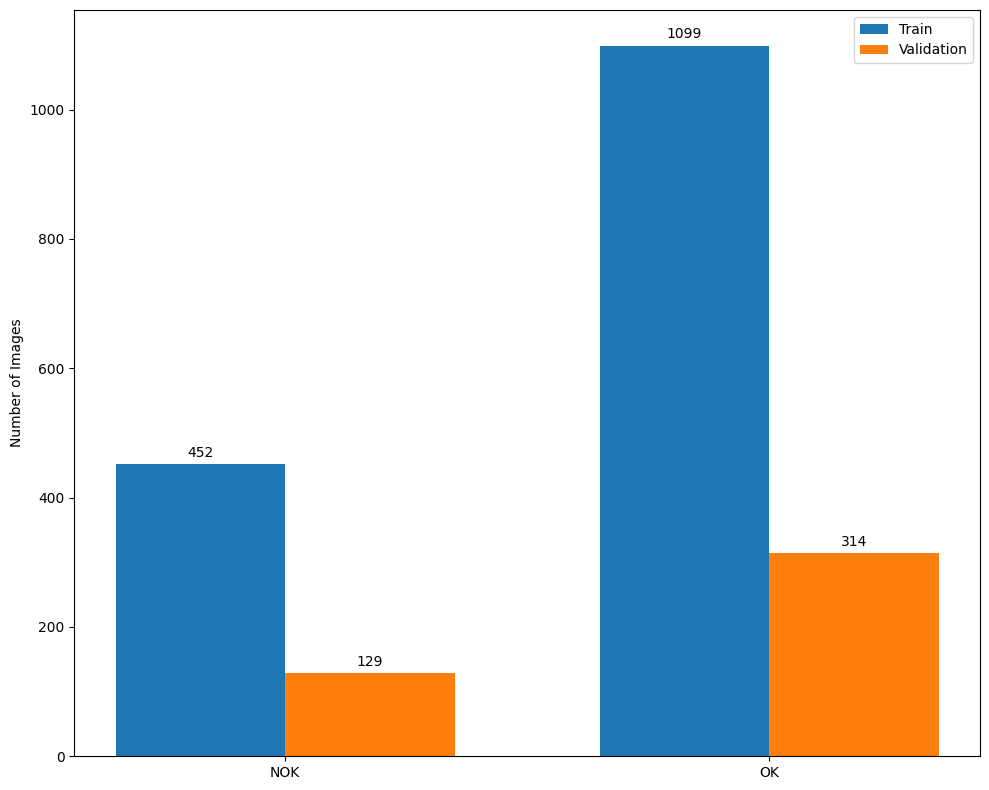

In [4]:
visualize_data(train_dir, val_dir)

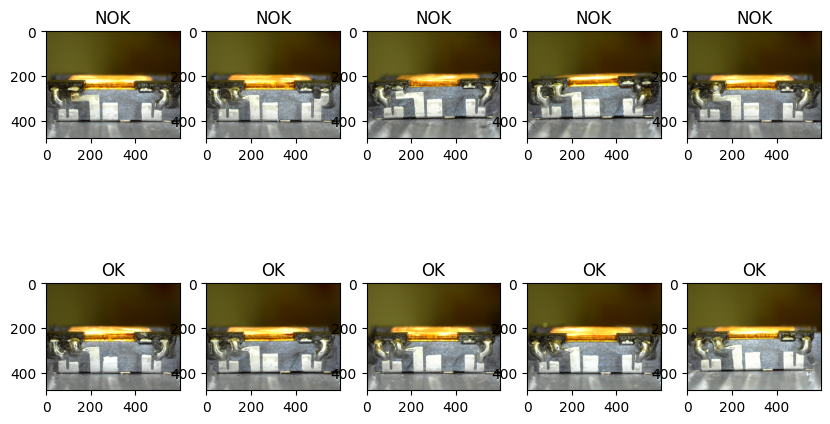

In [5]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "NOK")
pass_train_dir = os.path.join(data_dir, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("NOK")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("OK")

plt.show()

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2 
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 1551 images belonging to 2 classes.


In [4]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 443 images belonging to 2 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    shuffle = False,
    seed=42
    )

Found 222 images belonging to 2 classes.


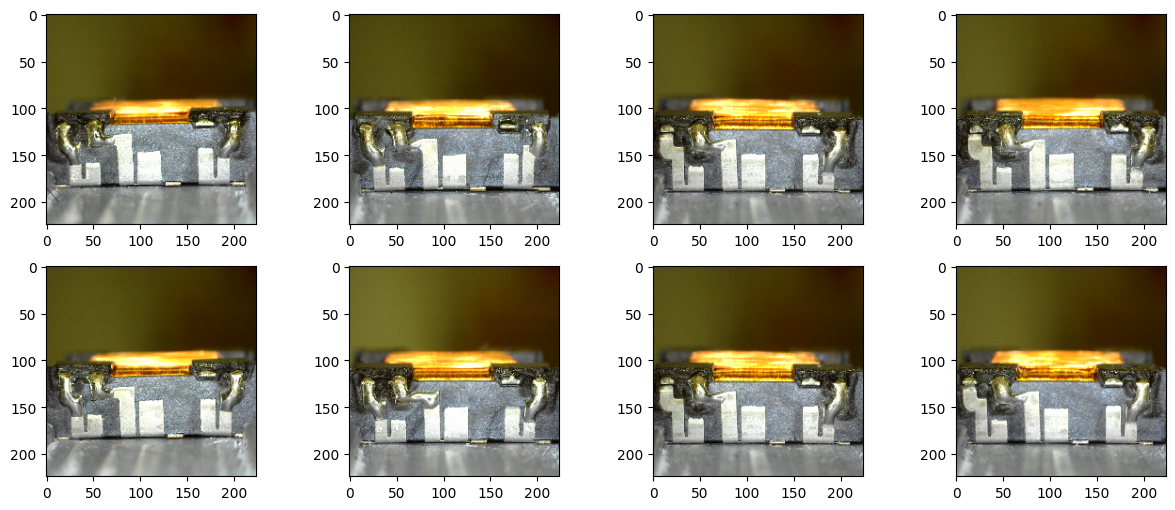

In [9]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [10]:
class_names = train_data.class_indices
class_names

{'NOK': 0, 'OK': 1}

In [11]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [12]:
class_weight_dict

{0: 1.7157079646017699, 1: 0.7056414922656961}

In [13]:
base_model = Xception(
        weights='imagenet', # Load pre-trained weights from the ImageNet dataset
        include_top=False, # Set to False to exclude the top fully connected layers from the model
        input_shape=(img_width, img_height, 3) # The input shape of the images
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fa239f0cb50>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa239d7fa90>,block1_conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa239d652b0>,block1_conv1_bn,False
3,<keras.layers.core.activation.Activation object at 0x7fa239d655e0>,block1_conv1_act,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa239cb5340>,block1_conv2,False
...,...,...,...
129,<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7fa2386338b0>,block14_sepconv2,False
130,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa239c2bc70>,block14_sepconv2_bn,False
131,<keras.layers.core.activation.Activation object at 0x7fa238638c40>,block14_sepconv2_act,False
132,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa23a236f40>,global_average_pooling2d,True


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [17]:
recall = Recall()
precision = Precision()

In [18]:
optimizer = SGD(learning_rate=0.01, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [19]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [20]:
EPOCHS = 10

num_workers = multiprocessing.cpu_count()
#workers=num_workers,
#use_multiprocessing=True,
#class_weight=class_weight_dict
history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb],
                      class_weight=class_weight_dict
                  )

Epoch 1/10


2023-04-11 19:55:46.611592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.6011 - recall: 0.6063 - precision: 0.7847

2023-04-11 19:57:05.542591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 101s 2s/step - loss: 0.6630 - accuracy: 0.6011 - recall: 0.6063 - precision: 0.7847 - val_loss: 0.5382 - val_accuracy: 0.7380 - val_recall: 0.7381 - val_precision: 0.8715
Epoch 2/10
48/48 [==============================] - 95s 2s/step - loss: 0.5111 - accuracy: 0.7643 - recall: 0.7677 - precision: 0.8844 - val_loss: 0.6020 - val_accuracy: 0.6346 - val_recall: 0.5288 - val_precision: 0.9231
Epoch 3/10
48/48 [==============================] - 94s 2s/step - loss: 0.4942 - accuracy: 0.7577 - recall: 0.7498 - precision: 0.8906 - val_loss: 0.4357 - val_accuracy: 0.8438 - val_recall: 0.8776 - val_precision: 0.8990
Epoch 4/10
48/48 [==============================] - 94s 2s/step - loss: 0.4462 - accuracy: 0.7992 - recall: 0.8039 - precision: 0.9020 - val_loss: 0.4561 - val_accuracy: 0.8053 - val_recall: 0.7993 - val_precision: 0.9192
Epoch 5/10
48/48 [==============================] - 92s 2s/step - loss: 0.4169 - accuracy: 0.8433 - recall: 0.8353 - preci

In [21]:
len(base_model.layers)

132

In [ ]:
base_model.trainable = True
# Freeze the first 100 layers 
for layer in base_model.layers[:600]:
  layer.trainable = False

In [22]:
for layer in base_model.layers:
  layer.trainable = True

In [23]:
optimizer = SGD(learning_rate=0.001, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [24]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fa239f0cb50>,input_1,True
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa239d7fa90>,block1_conv1,True
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa239d652b0>,block1_conv1_bn,True
3,<keras.layers.core.activation.Activation object at 0x7fa239d655e0>,block1_conv1_act,True
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa239cb5340>,block1_conv2,True
...,...,...,...
129,<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7fa2386338b0>,block14_sepconv2,True
130,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa239c2bc70>,block14_sepconv2_bn,True
131,<keras.layers.core.activation.Activation object at 0x7fa238638c40>,block14_sepconv2_act,True
132,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa23a236f40>,global_average_pooling2d,True


In [25]:
df['Layer Trainable'].value_counts()[True]

134

In [26]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [27]:
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [28]:
checkpoint_cb = ModelCheckpoint('model_1.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [29]:
EPOCHS = 100

num_workers = multiprocessing.cpu_count()

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb,checkpoint_cb, reduce_lr_cb],
                      class_weight=class_weight_dict
                   )

Epoch 1/100


2023-04-11 20:09:31.512458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.6359 - recall: 0.6240 - precision: 0.8923

2023-04-11 20:16:20.344125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 429s 9s/step - loss: 0.5981 - accuracy: 0.6359 - recall: 0.6240 - precision: 0.8923 - val_loss: 0.4386 - val_accuracy: 0.7981 - val_recall: 0.9966 - val_precision: 0.7810 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 435s 9s/step - loss: 0.3829 - accuracy: 0.8637 - recall: 0.8397 - precision: 0.9638 - val_loss: 0.3814 - val_accuracy: 0.8341 - val_recall: 0.9932 - val_precision: 0.8128 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 426s 9s/step - loss: 0.2420 - accuracy: 0.9506 - recall: 0.9433 - precision: 0.9864 - val_loss: 0.3110 - val_accuracy: 0.8630 - val_recall: 0.9932 - val_precision: 0.8415 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 420s 9s/step - loss: 0.1718 - accuracy: 0.9829 - recall: 0.9796 - precision: 0.9962 - val_loss: 0.2473 - val_accuracy: 0.8846 - val_recall: 0.9864 - val_precision: 0.8683 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 426s 9s/ste

In [31]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()

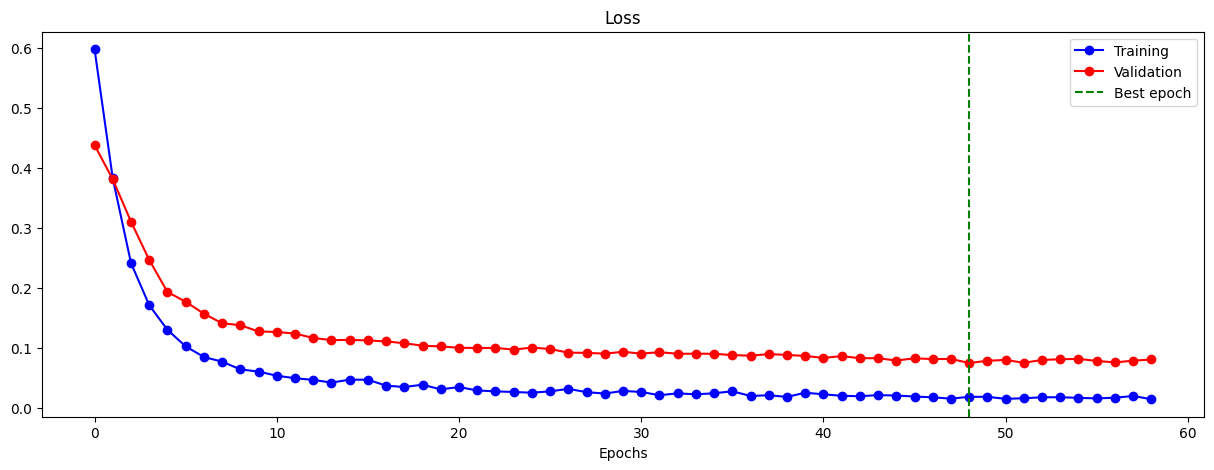

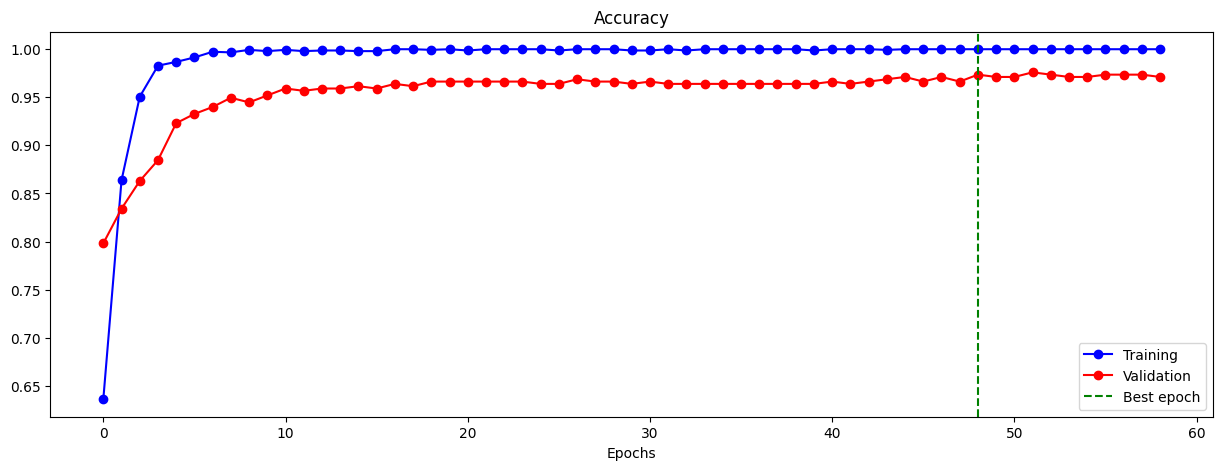

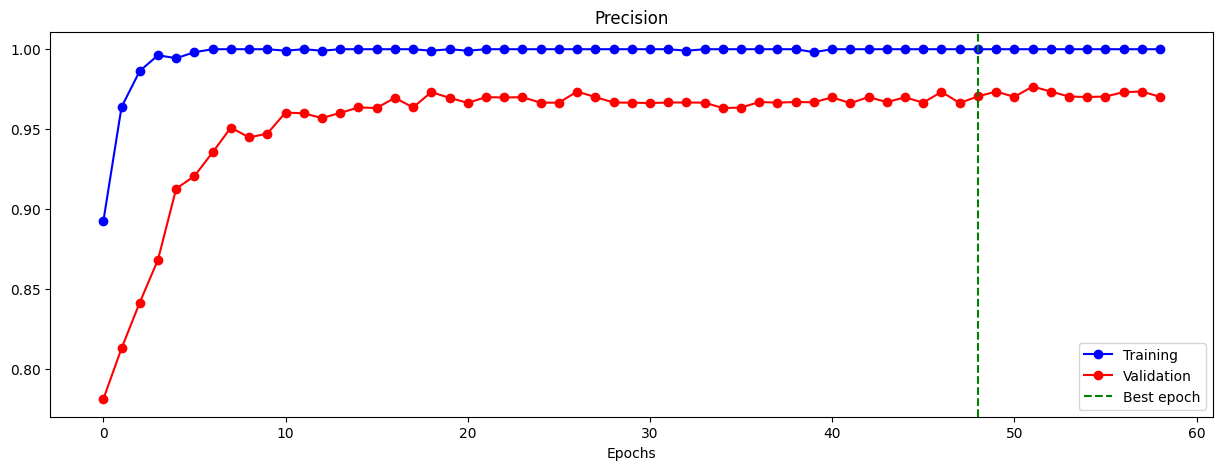

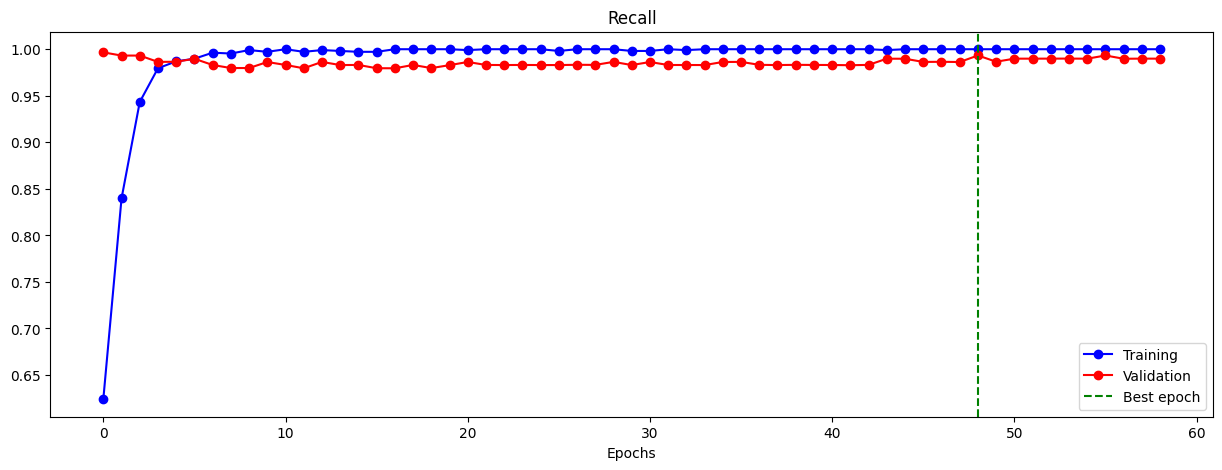

In [32]:
visualize_training_results(history)

In [6]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
   
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


In [8]:
from keras.models import load_model

In [9]:
checkpoint_model = load_model('model_1.h5')

In [10]:
checkpoint_model

2023-05-03 19:21:26.664598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 13s 2s/step


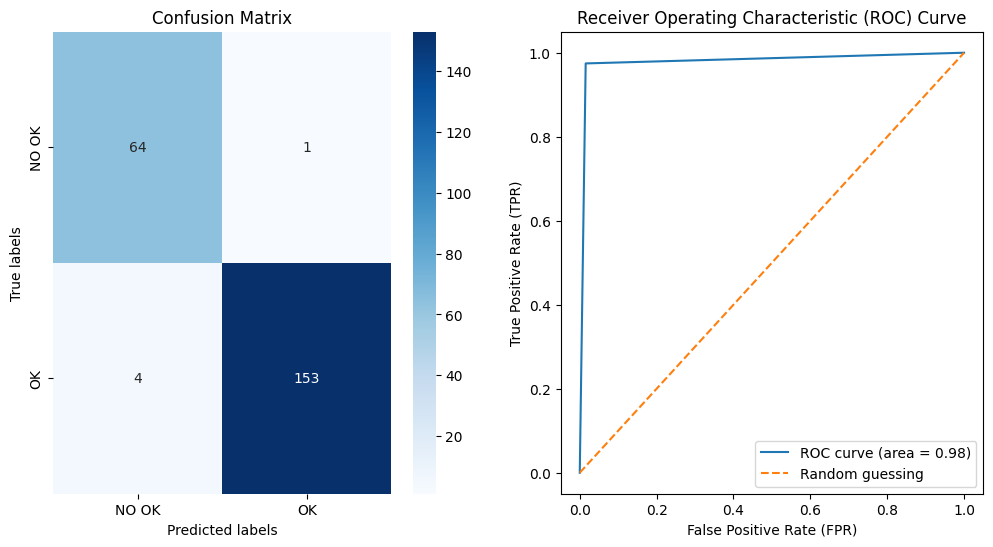

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        65
           1       0.99      0.97      0.98       157

    accuracy                           0.98       222
   macro avg       0.97      0.98      0.97       222
weighted avg       0.98      0.98      0.98       222



In [11]:
plot_metrics(checkpoint_model, test_data)

In [35]:
# Print the metrics of the best epoch
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch: ", best_epoch)
print("Best loss: ", history.history['loss'][best_epoch])
print("Best accuracy: ", history.history['accuracy'][best_epoch])
print("Best recall: ", history.history['recall'][best_epoch])
print("Best precision: ", history.history['precision'][best_epoch])
print("Best val_loss: ", history.history['val_loss'][best_epoch])
print("Best val_accuracy: ", history.history['val_accuracy'][best_epoch])
print("Best val_recall: ", history.history['val_recall'][best_epoch])
print("Best val_precision: ", history.history['val_precision'][best_epoch])

Best epoch:  48
Best loss:  0.019242089241743088
Best accuracy:  1.0
Best recall:  1.0
Best precision:  1.0
Best val_loss:  0.07549852877855301
Best val_accuracy:  0.973557710647583
Best val_recall:  0.9932885766029358
Best val_precision:  0.9704918265342712
